              precision    recall  f1-score   support

  Droite_Pct       1.00      0.67      0.80         3
  Gauche_Pct       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3

Accuracy: 0.72 (+/- 0.42)


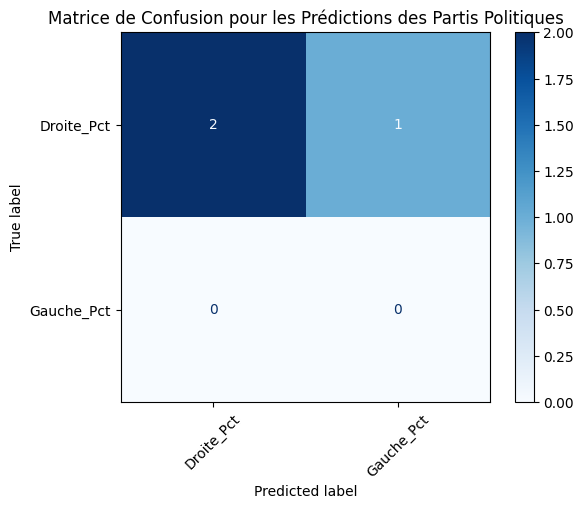

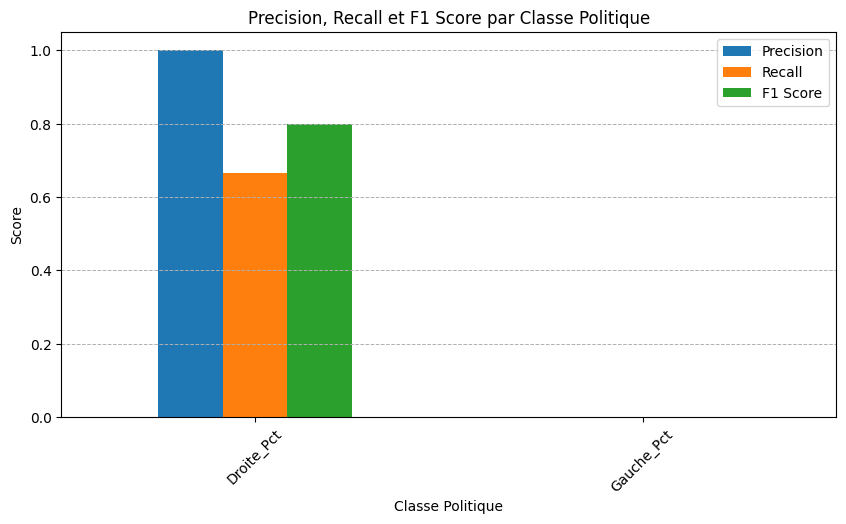

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


# Load the data
data = pd.read_parquet('../dataset/dataframe_politique_pouvoir_achat_chomage.parquet')

# Drop the columns that are not needed
# drop columns 'département'
data = data.drop(columns=['département'])
data = data.drop(columns=['circonscription'])

for col in data.columns:
    if data[col].dtype == object:
        data[col] = data[col].str.replace(',', '.').astype(float)

# Remplacer les virgules par des points et convertir en float
for col in ['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']:
    data[col] = data[col].astype(float)

y = data[['Extrême gauche_Pct', 'Gauche_Pct', 'Droite_Pct', 'Extrême droite_Pct']]. 

features = ['Code département', 'Inscrits', 'Votants', 'Exprimés', 'Blancs et nuls', 'Pouvoir d\'achat par unité de consommation', 'Pouvoir d’achat du revenu disponible brut', 'Chomage']
X = data[features]


# Division en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, zero_division=0))

# Utilisation de StratifiedKFold pour assurer la distribution équilibrée des classes
skf = StratifiedKFold(n_splits=3)  # Réduisez le nombre de plis si nécessaire
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Prédiction pour l'ensemble de test
predictions = model.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Affichage de la matrice de confusion
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion pour les Prédictions des Partis Politiques')
plt.xticks(rotation=45)
plt.show()


# Calcul des métriques pour chaque classe
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, predictions, labels=model.classes_, zero_division=0)

# Création d'un DataFrame pour les métriques
class_report_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': fscore
}, index=model.classes_)

# Tracé des métriques
class_report_df.plot(kind='bar', figsize=(10, 5))
plt.title('Precision, Recall et F1 Score par Classe Politique')
plt.xlabel('Classe Politique')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(loc='upper right')
plt.show()



